In [1]:
import json
import pandas as pd
from development.datasets.osdg_dataset import load_osdg_data
from development.datasets.ucl_modules.uclmodules_dataset import load_uclmodules_data
from development.datasets.relx_dataset import load_relx_data
from development.models.Bert import Bert
from development.models.BertMultiLabel import BertMultiLabel
from development.train_model import fine_tune_transformer
from development.pipelines import full_pipe
from development.utils import parse_sdg_id

In [25]:
%load_ext autoreload
%autoreload 2
pd.set_option('max_colwidth', None)
# pd.set_option('max_rowwidth', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
with open('config.json', 'r') as file:
    CONFIG = json.load(file)
    dev_config = CONFIG['development']


In [4]:
osdg_data = load_osdg_data(
    dev_config['osdg_data_path'],
    training=False,
    filter_agreement=False
)

In [367]:
osdg_data.groupby(['sdg']).count()['text']

sdg
1     2734
2     2457
3     2689
4     3740
5     4338
6     2815
7     3048
8     1509
9     2105
10    2032
11    2277
12    1108
13    2102
14    1141
15    2143
16    5451
Name: text, dtype: int64

In [11]:
ucl_data = load_uclmodules_data(
    dev_config['uclmodules_data_path'],
    only_labled=True
)

<h1 style="color: pink">Single Label Training</h1>

In [39]:
osdg_data = load_osdg_data(
    dev_config['osdg_data_path'],
    training=True,
    filter_agreement=False
)

In [8]:
bert = Bert()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

In [ ]:
result = fine_tune_transformer(
    bert.model,
    bert.tokenizer,
    bert.tokenizer_args,
    data=osdg_data,
    dev_config=dev_config
)

In [43]:
bert = Bert('./development/weights/Bert-5/checkpoint-6384/')

In [ ]:
cls_report = bert.evaluate(osdg_data['train'])
print(cls_report)

In [ ]:
cls_report = bert.evaluate(osdg_data['valid'])
print(cls_report)

In [ ]:
cls_report = bert.evaluate(osdg_data['test'])
print(cls_report)

<h1 style="color: pink">NER Model</h1>

In [ ]:
from development.models.RobertaNER import RobertaNER

In [48]:
ner_model = RobertaNER()

In [27]:
ner_model.print_entities(osdg_data['train'][0][14])

ORG: The World Resources Institute
ORG: World Resources Institute


In [76]:
df = full_pipe(bert, ner_model, texts=[osdg_data['train'][0][7]])

,Text,SDG,Entities,Sentiment
0,"This is why the Sustainable Development of Protected Areas System of Ethiopia was set up, with support from the Global Environment Fund and UNDP. The project is spearheading a suite of interventions, focusing on the national system in terms of capacity building and training, and integrating the protected area system into mainstream development. Since the initiation of the project in 2008, valuation exercises have found that the main value of protected areas is in the environmental services that they provide to poor rural communities, many of which are food-insecure, protected areas were incorporated into the Ethiopia Poverty Strategy, and the legal boundaries of the protected area system were strengthened by supporting the demarcation and gazettement of four areas through a highly consultative process (UNDP, n.d.).",Climate Action,ORG: the Sustainable Development of Protected Areas System of Ethiopia - ORG: the Global Environment Fund - ORG: UNDP - ORG: UNDP -,NULL


<h1 style="color: pink">Relx Data Scraping</h1>

In [ ]:
from development.scrape.RelxScraper import RelxScraper

In [138]:
relx_scraper = RelxScraper()
relx_scraper.scrape_data(start=0)
relx_scraper.save_as_csv('./data/relx_data.csv')

<h1 style="color: pink">Multi-label Fine-tuning</h1>

In [5]:
bert_multilabel = BertMultiLabel(
    './development/weights/Bert-5/checkpoint-6384/'
)

In [7]:
relx_training_data = load_relx_data(
    data_path=dev_config['relx_data_path'],
    training=True
)

In [ ]:
results = fine_tune_transformer(
    bert_multilabel.model,
    bert_multilabel.tokenizer,
    bert_multilabel.tokenizer_args,
    data=relx_training_data,
    dev_config=dev_config
)

In [43]:
bert_multilabel = BertMultiLabel(
    './development/weights/Bert-Multilabel-5/checkpoint-1400/'
)
bert_multilabel.to_gpu()

In [7]:
cls_report = bert_multilabel.evaluate(relx_training_data['train'])
print(cls_report)

              precision    recall  f1-score   support

           0       1.00      0.36      0.53        14
           1       0.91      0.96      0.94        77
           2       0.99      0.93      0.96       543
           3       1.00      0.61      0.76        23
           4       0.98      0.89      0.93        53
           5       0.97      0.93      0.95        99
           6       0.90      0.88      0.89        42
           7       1.00      0.33      0.50        21
           8       0.80      0.69      0.74        51
           9       0.95      0.62      0.75       166
          10       0.99      0.83      0.90        99
          11       0.90      0.70      0.79        61
          12       0.99      0.83      0.90       222
          13       0.98      0.87      0.92        54
          14       0.80      0.84      0.82        77
          15       0.68      0.48      0.57        27

   micro avg       0.95      0.83      0.89      1629
   macro avg       0.93   

In [10]:
cls_report = bert_multilabel.evaluate(relx_training_data['valid'])
print(cls_report)

              precision    recall  f1-score   support

           0       1.00      0.00      0.00         1
           1       0.71      0.83      0.77        12
           2       0.92      0.86      0.89        98
           3       0.75      0.60      0.67         5
           4       0.60      0.33      0.43         9
           5       0.60      0.75      0.67        16
           6       0.60      0.43      0.50         7
           7       1.00      0.00      0.00         1
           8       0.33      0.38      0.35         8
           9       0.85      0.48      0.61        23
          10       0.67      0.50      0.57        12
          11       0.50      0.33      0.40        12
          12       0.87      0.60      0.71        43
          13       0.75      0.60      0.67         5
          14       0.47      0.54      0.50        13
          15       0.50      0.40      0.44         5

   micro avg       0.77      0.66      0.71       270
   macro avg       0.69   

In [15]:
cls_report = bert_multilabel.evaluate(relx_training_data['test'])
print(cls_report)

              precision    recall  f1-score   support

           0       1.00      0.00      0.00         1
           1       0.79      0.73      0.76        15
           2       0.97      0.85      0.90       100
           3       1.00      0.00      0.00         6
           4       0.75      0.60      0.67        10
           5       0.91      0.83      0.87        12
           6       0.70      0.70      0.70        10
           7       1.00      0.00      0.00         4
           8       0.17      0.12      0.14         8
           9       0.62      0.45      0.52        29
          10       0.40      0.27      0.32        15
          11       0.67      0.40      0.50        10
          12       0.89      0.63      0.74        38
          13       0.89      0.80      0.84        10
          14       0.60      0.50      0.55        12
          15       1.00      0.29      0.44         7

   micro avg       0.82      0.63      0.71       287
   macro avg       0.77   

In [18]:
cls_report = bert_multilabel.evaluate_single_label(
    osdg_data['test'],
    mode='exact_match'
)
print(cls_report)

A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'


              precision    recall  f1-score   support

           0       0.94      0.61      0.74       410
           1       0.92      0.88      0.90       369
           2       0.62      0.99      0.76       404
           3       0.92      0.90      0.91       561
           4       0.93      0.89      0.91       651
           5       0.91      0.85      0.88       423
           6       0.97      0.81      0.88       457
           7       0.84      0.64      0.72       226
           8       0.90      0.84      0.87       316
           9       0.51      0.87      0.65       305
          10       0.78      0.93      0.84       341
          11       0.97      0.61      0.75       166
          12       0.71      0.91      0.80       315
          13       0.96      0.87      0.91       171
          14       0.90      0.88      0.89       321
          15       1.00      0.82      0.90       818

    accuracy                           0.84      6254
   macro avg       0.86   

In [19]:
accuracy = bert_multilabel.evaluate_single_label(
    osdg_data['test'],
    mode='included'
)
accuracy

0.9267668692037097

In [24]:
ucl_data = load_uclmodules_data(
    dev_config['uclmodules_data_path'],
    only_labled=True,
    evaluation=True
)

In [59]:
cls_report = bert_multilabel.evaluate(ucl_data)
print(cls_report)

              precision    recall  f1-score   support

           0       0.80      0.09      0.16        87
           1       0.30      0.58      0.40        12
           2       0.84      0.90      0.87      1015
           3       0.17      0.88      0.29       258
           4       0.37      0.72      0.49       128
           5       0.26      0.83      0.40        18
           6       0.62      0.62      0.62        76
           7       0.70      0.35      0.47       339
           8       0.62      0.67      0.64       588
           9       0.07      0.60      0.13        53
          10       0.68      0.42      0.52       506
          11       0.10      0.33      0.16        24
          12       0.26      0.74      0.39        68
          13       0.58      0.55      0.56        20
          14       0.21      0.67      0.32        18
          15       0.66      0.62      0.64       667

   micro avg       0.48      0.66      0.56      3877
   macro avg       0.45   

<h1 style="color: pink">Multi-label Manual Validations</h1>

'Cardiac Critical Care (CHLD0081) \n Summary\nThis module will introduce principles of paediatric cardiology and cardiac intensive care. Over the course of the week, we will discuss cardiac anatomy and physiology, before moving on to post-natal management of cardiac disease, and subsequent management at specialist centres from the perspectives of the cardiologist, the anaesthetic and surgical teams, as well as the cardiac intensive care team. We will also spend some time looking at arrhythmia, pulmonary hypertension and heart failure, with a focus on underlying pathophysiology and management strategies (including mechanical circulatory support).\nYou will also critically review literature and latest advancements in the field, and present this in a poster with an oral session.\nLearning objectives and outcomes\nAfter taking this module, you will be able to:\nDescribe the underlying physiology & anatomy of paediatric cardiac disease.\nUnderstand the principles of management – both surgical and medical.\nDescribe and suggest management strategies for arrhythmia\nUnderstand the pathophysiology of pulmonary hypertension and heart failure\nDescribe management strategies for the above.\n\nWho is this module for?\n\nThis is a core module for the MSc Paediatrics and Child Health: Intensive Care and an optional module for all other MSc Paediatric and Child Health Pathways, aimed at those with a genuine interest in cardiology and cardiac critical care.\nTeaching and Learning Methods\nYou will receive 5 days of interactive online lectures/workshops, which will supplement learning through self-directed study.\n\nAssessment\n\nYou will need to create a poster and up to date literature review on a topic relevant to the module. You will also be assessed via oral presentation of the topic to the examiners and student group.'


In [114]:
ucl_data[0][590]

'Conflict of Laws (LAWS0034) \n Knowledge of the Conflict of Laws (also known as Private International Law) is essential for any lawyer who aspires to work in any area of practice that transcends national frontiers, whether as a specialist in dispute resolution or in advisory work. London is one of the leading centres for international commercial dispute resolution, and most of the commercial disputes heard in London involve foreign parties, so Conflict of Laws rules are particularly central to the work of the English commercial courts. It is a fascinating area of the law, and one of enormous practical importance as legal relationships and disputes increasingly cross borders, but also one of the most intellectually demanding.\nYou will deal principally with three separate questions which may arise in cross-border civil and commercial litigation:\njurisdiction, the question of which court may hear a dispute;\napplicable law, the question of which law or laws a court will apply to resolv

In [113]:
for label in ucl_data[1][590]:
    print(f'SDG ID: {label+1}, SDG: {parse_sdg_id(label)}')

SDG ID: 16, SDG: Peace, Justice, and Strong Institutions
SDG ID: 8, SDG: Decent Work and Economic Growth


In [49]:
predictions = bert_multilabel.predict(ucl_data[0][590])
predictions = bert_multilabel.parse_predictions(
    predictions,
    top_k=16,
    threshold=0.7
)

for prediction in predictions[0]:
    print(f'SDG ID: {prediction+1}, SDG: {parse_sdg_id(prediction)}')

SDG ID: 13, SDG: Climate Action
SDG ID: 9, SDG: Industry, Innovation, and Infrastructure


<h1 style="color: pink">Interpretability</h1>

In [6]:
from development.interpretability.Interpreter import Interpreter

In [7]:
interpreter = Interpreter(interpreter_type='lime')

In [58]:
interpreter.print_interpreter_parameters()


            Parameter Name - Data Type - Explaination

            1. input_text - string - input text for the model
            2. transformer - Object - hugging face transformer for text classification
            3. show - Bool - Whether to show lime explaination or not
        


In [11]:
interpreter.interpret(
    input_text=osdg_data['test'][0][190],
    transformer=bert,
    show=True
)

In [64]:
interpreter.interpreter = 'attention_heatmap'
interpreter.print_interpreter_parameters()


            Parameter Name - Data Type - Explaination

            1. input_text - string - input text for the model
            2. transformer - Object - hugging face transformer for text classification
            3. attention_head_id - int - Id of attention head to visualize
        


In [ ]:
interpreter.interpret(
    input_text=osdg_data['test'][0][2],
    transformer=bert,
    attention_head_id=0
)

<h1 style="color: pink">UCL Data re-labeling</h1>

In [15]:
bert_multilabel = BertMultiLabel(
    './development/weights/Bert-Multilabel-5/checkpoint-1400/'
)
bert_multilabel.to_gpu()

In [ ]:
from development.datasets.ucl_modules.uclmodules_dataset import relabel_ucl_data

relabel_ucl_data(
    dev_config['uclmodules_data_path'],
    bert_multilabel,
    output_path='output.xlsx'
)

In [391]:
from development.datasets.ucl_modules.report_generators import generate_reports

reports = generate_reports(
    'output.xlsx',
    append=True,
    report_names=['Report 1', 'Report 2']
)

<h1 style="color: pink">UCL Data Visualizations</h1>

In [4]:
ucl_data = pd.read_excel(dev_config['uclmodules_data_path_v2'])

In [65]:
from development.datasets.ucl_modules.Visualizer import Visualizer

In [66]:
ucl_visualizer = Visualizer(ucl_data)

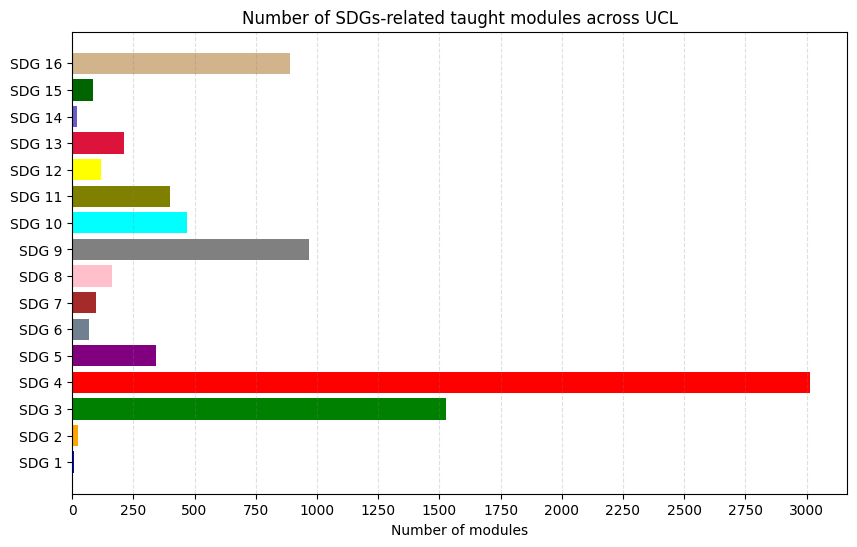

In [67]:
ucl_visualizer.sdgs_count()

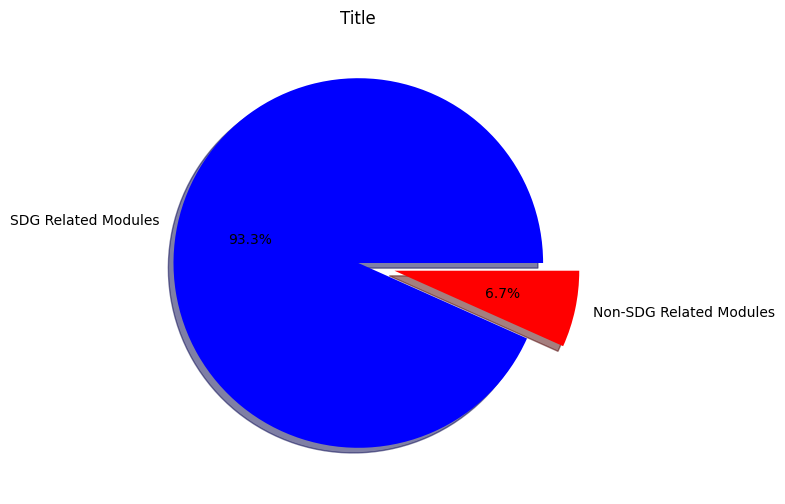

In [68]:
ucl_visualizer.sdg_nosdg_pie()

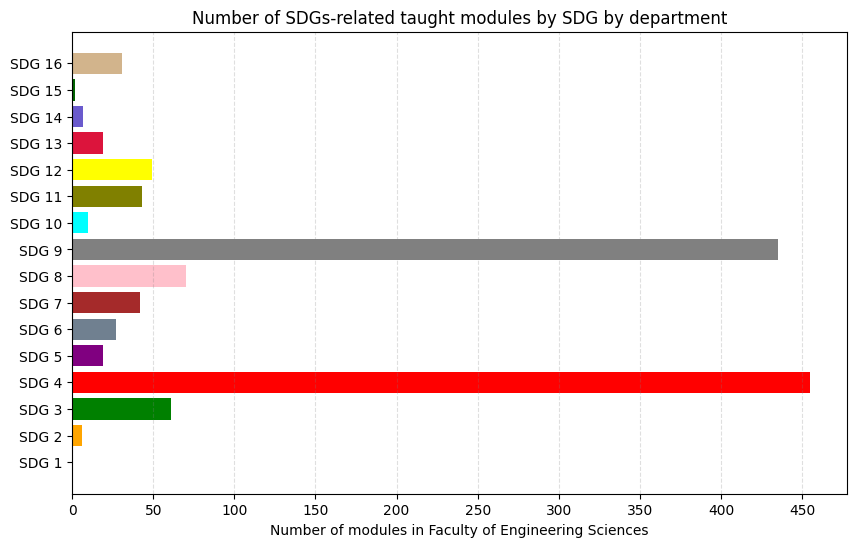

In [69]:
ucl_visualizer.sdgs_count_faculty(faculty_name='Faculty of Engineering Sciences')

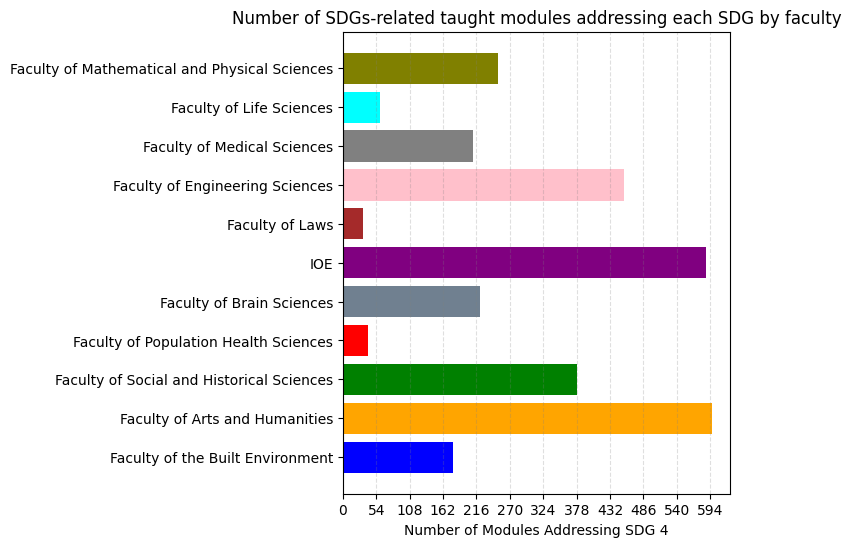

In [79]:
ucl_visualizer.sdg_count_faculty(sdg_id=4)

In [33]:
pd.DataFrame(ucl_data.iloc[750][[
    'heading',
    'Faculty',
    'Teaching department',
    'full_text',
    'text_len',
    'final_sdg_labels'
]]).T

,heading,Faculty,Teaching department,full_text,text_len,final_sdg_labels
750,Cancer Clinical Trials - Undergraduate (CINS0015),Faculty of Medical Sciences,Cancer Institute,"Cancer Clinical Trials - Undergraduate (CINS0015) \n In this module students will gain knowledge of the development pathway for new cancer interventions, from first-in-man to licensed product through to clinical practice. Students will learn about the different phases of cancer clinical trials and the main design and practical issues associated with conducting, interpreting and reporting cancer trials. Students will get a grounding in how these complex and closely regulated studies are performed by researchers active in, and at the forefront of, the field. A greater understanding of the biology of cancer has led to the development of specifically targeted interventions and advanced therapies (gene, cell and tissues) to treat cancer and the possibility of personalised (also called stratified) medicine which is impacting on cancer trial methodology. Although the focus is on cancer trials the skills gained are transferable to other disease areas.",141,Quality Education -Good Health and Well-Being -
